# Assignment 2 
## DECISION TREE

DSCI 6601: Practical Machine Learning

Student: Sahil Khan

Date: 08-Oct-2024
_____________________________________________________________________________________________________________________________________________________________________________________________

### INTRODUCTION

For this assignment, we chose a publicly available dataset on kaggle that contains at least five features. The goal is to build a Decision Tree Classifier depending on the nature of our dataset. We will evaluate the model’s performance and analyze how the features contribute to the predictions. We will complete the tasks outlined below, and ensure to include both our Python code and the dataset in our submission.

Dataset Link: https://www.kaggle.com/datasets/taweilo/mba-admission-dataset/data

_____________________________________________________________________________________________________________________________________________________________________________________________

### IMPORTING LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

## TASK 1: Dataset Overview 
- We will provide a basic overview of the dataset, including details such as feature names, target variable, presence of missing values, and identification of categorical features.

In [2]:
mbaData = pd.read_csv('MBA.csv')
mbaData.head()

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,NaN
2,3,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,NaN
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,NaN


In [3]:
mbaData.shape   # Count of Rows and Columns

(6194, 10)

In [4]:
mbaData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6194 entries, 0 to 6193
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   application_id  6194 non-null   int64  
 1   gender          6194 non-null   object 
 2   international   6194 non-null   bool   
 3   gpa             6194 non-null   float64
 4   major           6194 non-null   object 
 5   race            4352 non-null   object 
 6   gmat            6194 non-null   float64
 7   work_exp        6194 non-null   float64
 8   work_industry   6194 non-null   object 
 9   admission       1000 non-null   object 
dtypes: bool(1), float64(3), int64(1), object(5)
memory usage: 441.7+ KB


- FEATURE NAMES AND TARGET VARIABLES

In [5]:
print("FEATURES NAMES:", mbaData.columns.tolist()) # Features Names
print("TARGET VARIABLE:", (mbaData.columns.tolist()[-1].upper())) # Target Variable

FEATURES NAMES: ['application_id', 'gender', 'international', 'gpa', 'major', 'race', 'gmat', 'work_exp', 'work_industry', 'admission']
TARGET VARIABLE: ADMISSION


- PRESENCE OF MISSING VALUES

In [6]:
mbaData.isnull().sum()

application_id       0
gender               0
international        0
gpa                  0
major                0
race              1842
gmat                 0
work_exp             0
work_industry        0
admission         5194
dtype: int64

- CATEGORICAL COLUMNS

In [7]:
[col for col in mbaData.columns if mbaData[col].dtype == 'object']

['gender', 'major', 'race', 'work_industry', 'admission']

____________________________________________________________________________________________________________________________________________________________________________________________

## TASK 2: Data Preprocessing
We will describe how we would preprocess the dataset before building a Decision Tree model. We will state steps such as handling missing values, encoding categorical features, and scaling features if necessary.

#### Drop unnecessary columns

In [8]:
# Since application id is not significant in building a Decision Tree model, we are dropping the 'APPLICATION ID'
mbaData = mbaData.drop('application_id', axis=1)
mbaData.head()

,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,NaN
2,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,Male,False,3.47,STEM,Black,690.0,6.0,Technology,NaN
4,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,NaN


#### Handling Missing Values

In [9]:
mbaData.isnull().sum()

gender              0
international       0
gpa                 0
major               0
race             1842
gmat                0
work_exp            0
work_industry       0
admission        5194
dtype: int64

We can clearly see that race and admission column have missing values.

In [10]:
# Handling Missing Values in 'RACE' column
mbaData["race"]=mbaData['race'].fillna(mbaData['race'].mode()[0])

Since the RACE column is a categorical feature, the most common practice to handle missing values is to fill it with the mode() [the most occuring value] for the following reasons:
- Maintains the existing distribution of categorical data.
- Retains more data points for analysis by avoiding row deletion.
- Ensures imputed values are representative rather than arbitrary.

##### For the admission column, even though it is categorical and we could impute the missing values with the mode, we choose not to fill them because it serves as a target variable. Filling these missing values could introduce bias into the dataset.

In [11]:
mbaData['admission'].value_counts(dropna=False)

NaN         5194
Admit        900
Waitlist     100
Name: admission, dtype: int64

##### Given that the count of null values amounts to 5,194, we cannot afford to drop them, as this would result in a significant loss of data. Instead, we have replaced or encoded the values as follows: 'Admit' as 1, 'Waitlist' as 2, and null values as 0.
##### ADMISSION: 0 implicates 'Not Admitted'

In [12]:
mbaData['admission'] = mbaData['admission'].replace({'Admit': 1, 'Waitlist': 2})
mbaData['admission'] = mbaData['admission'].fillna(0)
mbaData['admission'].value_counts()

0.0    5194
1.0     900
2.0     100
Name: admission, dtype: int64

In [13]:
# Checking for null values after data preprocessing
mbaData.isnull().sum()

gender           0
international    0
gpa              0
major            0
race             0
gmat             0
work_exp         0
work_industry    0
admission        0
dtype: int64

In [14]:
mbaData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6194 entries, 0 to 6193
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         6194 non-null   object 
 1   international  6194 non-null   bool   
 2   gpa            6194 non-null   float64
 3   major          6194 non-null   object 
 4   race           6194 non-null   object 
 5   gmat           6194 non-null   float64
 6   work_exp       6194 non-null   float64
 7   work_industry  6194 non-null   object 
 8   admission      6194 non-null   float64
dtypes: bool(1), float64(4), object(4)
memory usage: 393.3+ KB


In [15]:
# Converting bool column to int to simplify the dataset for model building
mbaData['international'] = mbaData['international'].astype(int)
mbaData['international'].value_counts(dropna=False)

0    4352
1    1842
Name: international, dtype: int64

In [16]:
mbaData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6194 entries, 0 to 6193
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         6194 non-null   object 
 1   international  6194 non-null   int32  
 2   gpa            6194 non-null   float64
 3   major          6194 non-null   object 
 4   race           6194 non-null   object 
 5   gmat           6194 non-null   float64
 6   work_exp       6194 non-null   float64
 7   work_industry  6194 non-null   object 
 8   admission      6194 non-null   float64
dtypes: float64(4), int32(1), object(4)
memory usage: 411.4+ KB


- Applying One-Hot encoding to the categorical features

In [17]:
# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')

# List of columns to be tranformed
colList = [col for col in mbaData.columns if mbaData[col].dtype == 'object']

# Fit and transform the encoder to the selected categorical columns
mbaDataTemp = encoder.fit_transform(mbaData[colList])

# Create a DataFrame with the encoded columns
mbaEncodedTempDF = pd.DataFrame(mbaDataTemp, columns=encoder.get_feature_names_out(colList))

# Concatenate the original dataframe with the encoded columns
mbaDataEncoded = pd.concat([mbaData, mbaEncodedTempDF], axis=1)

# Drop original categorical columns
mbaDataEncoded = mbaDataEncoded.drop(columns=colList)

We used one-hot encoding to convert categorical variables into a format that machine learning models, like decision trees, can work with since they mostly use numerical data. This method changes categories into binary columns, allowing the model to process and understand these variables without assuming any order or ranking between them.

In [18]:
mbaDataEncoded.head()

,international,gpa,gmat,work_exp,admission,gender_Male,major_Humanities,major_STEM,race_Black,race_Hispanic,race_Other,race_White,work_industry_Consulting,work_industry_Energy,work_industry_Financial Services,work_industry_Health Care,work_industry_Investment Banking,work_industry_Investment Management,work_industry_Media/Entertainment,work_industry_Nonprofit/Gov,work_industry_Other,work_industry_PE/VC,work_industry_Real Estate,work_industry_Retail,work_industry_Technology
0,0,3.30,620.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,3.28,680.0,5.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,3.30,710.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,3.47,690.0,6.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,3.35,590.0,5.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- Given that the majority of the columns are within the range of 0 to 1, we will scale the following features to fall within this range:
1. GPA
2. GMAT
3. Work Experience

In [19]:
scaler = MinMaxScaler()

mbaDataEncoded[['gpa', 'gmat', 'work_exp']] = scaler.fit_transform(mbaDataEncoded[['gpa', 'gmat', 'work_exp']])
mbaDataEncoded

,international,gpa,gmat,work_exp,admission,gender_Male,major_Humanities,major_STEM,race_Black,race_Hispanic,race_Other,race_White,work_industry_Consulting,work_industry_Energy,work_industry_Financial Services,work_industry_Health Care,work_industry_Investment Banking,work_industry_Investment Management,work_industry_Media/Entertainment,work_industry_Nonprofit/Gov,work_industry_Other,work_industry_PE/VC,work_industry_Real Estate,work_industry_Retail,work_industry_Technology
0,0,0.580357,0.238095,0.250,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.562500,0.523810,0.500,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.580357,0.666667,0.500,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,0.732143,0.571429,0.625,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0.625000,0.095238,0.500,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6189,0,0.750000,0.333333,0.500,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6190,0,0.473214,0.476190,0.375,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6191,1,0.508929,0.523810,0.500,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6192,1,0.633929,0.095238,0.500,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


We are done with Data Preprocessing and now we'll begin with Model Implementation.
____________________________________________________________________________________________________________________________________________________________________________________________

## TASK 3: Model Implementation
- Implement a Decision Tree classifier using Scikit-learn.
- We will explain how we would split the data into training and testing sets, train the model, and evaluate it using appropriate metrics.

In [20]:
X = mbaDataEncoded.drop('admission', axis=1)    # Independent Features
y = mbaDataEncoded['admission']                 # Dependent Feature

- Splitting the data into 70% [Training Data] - 30% [Testing Data]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

In [22]:
dtClassifier = DecisionTreeClassifier() # Model Initialisation

In [23]:
dtClassifier.fit(X_train, y_train)  # Fiting the Model with Training Data

DecisionTreeClassifier()

In [24]:
# Predicting the Test set results
y_pred = dtClassifier.predict(X_test)

##### We are done with model building, model training and predicting the test set results.
##### Now we see how our model performs with the metrics like 'ACCURACY SCORE' and 'CONFUSION MATRIX'.

In [25]:
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy of Decision Tree classifier on test set:", accuracy)


Accuracy of Decision Tree classifier on test set: 0.7907477138246369


##### Our model performs with the 79% accuracy.

Here is the visualization of the trained Decision Tree, showing how the model makes decisions based on the features with max_depth to 3.

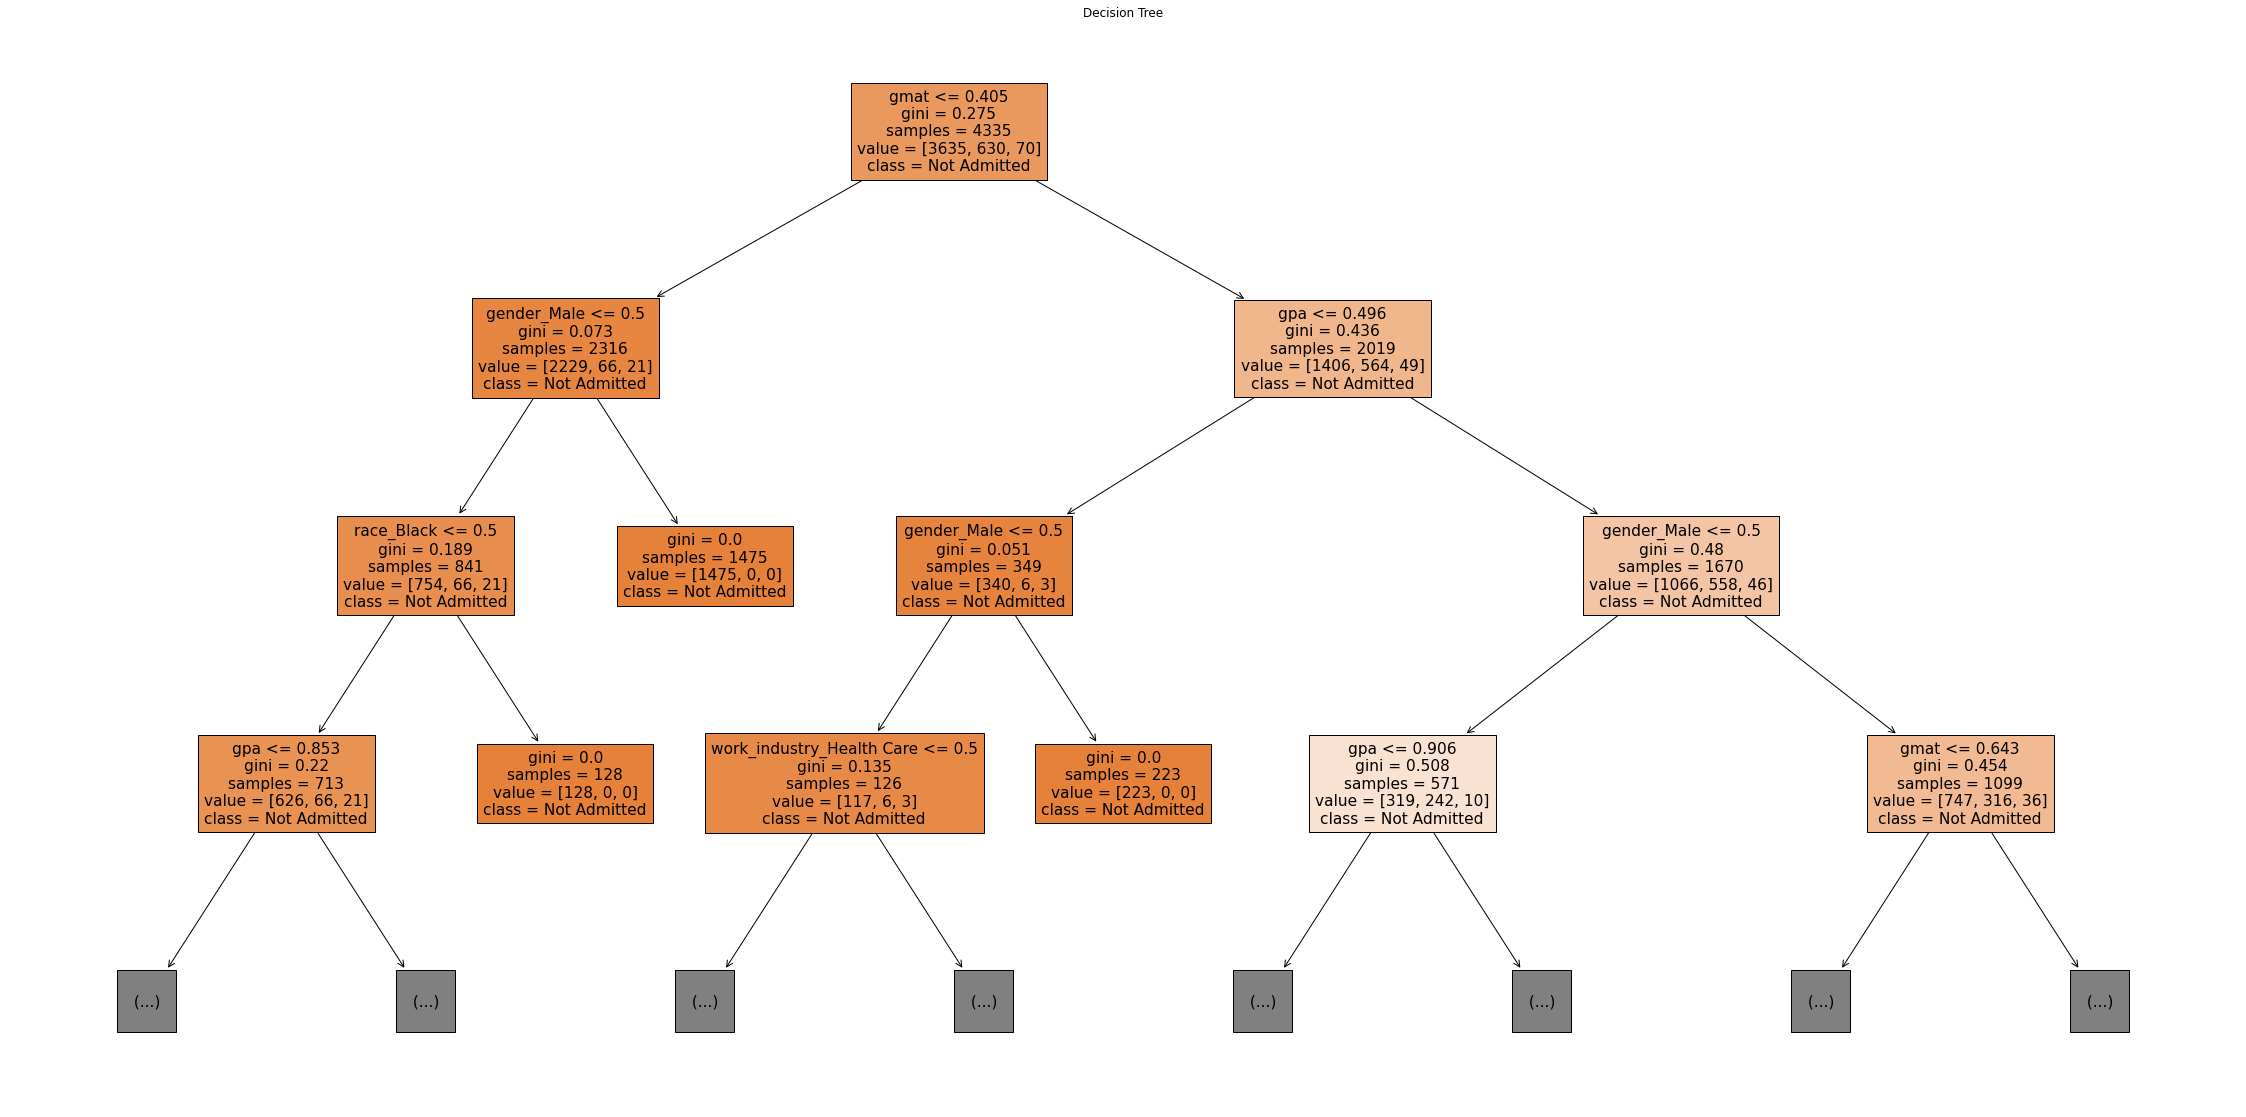

In [26]:
# Plot the decision tree
plt.figure(figsize=(40, 20))
plot_tree(dtClassifier, filled=True, feature_names=X_train.columns, class_names=['Not Admitted', 'Admitted', 'Waitlisted'],max_depth=3)
plt.title('Decision Tree')
plt.show()

We can clearly see that our Decision Trees make splits based on the feature named GMAT that has lower gini impurity which indicates that the resulting node is more homogeneous (more instances belong to a single class), which is desirable for making accurate predictions.

Although we fill further analyse the feature importance and Information gain.

#### Plotting Scatterplot of GMAT vs ADMISSION

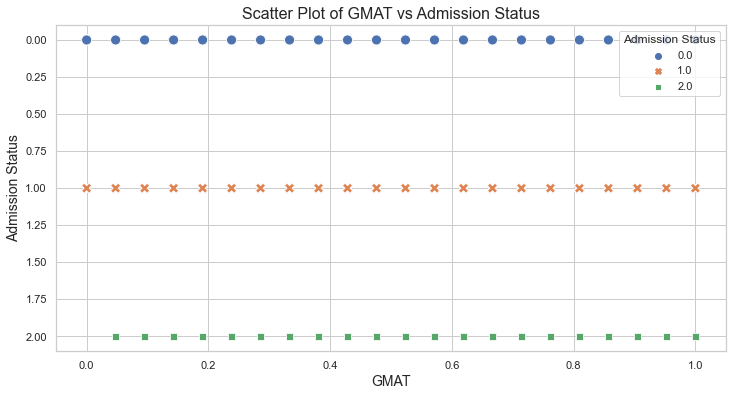

In [27]:
# Convert admission status to a categorical variable for plotting
mbaDataEncoded['admission'] = mbaDataEncoded['admission'].astype('category')

# Set the style of the visualization
sns.set(style='whitegrid')

# Create the scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=mbaDataEncoded, x='gmat', y='admission', hue='admission', style='admission', palette='deep', s=100)

# Customize the plot
plt.title('Scatter Plot of GMAT vs Admission Status', fontsize=16)
plt.xlabel('GMAT', fontsize=14)
plt.ylabel('Admission Status', fontsize=14)
plt.legend(title='Admission Status', loc='upper right')
plt.grid(True)

# Show the plot
plt.show()


- The scatter plot above does not effectively illustrate the significant differences in GMAT scores across the three admission categories. 
- However, selecting GMAT as the root node demonstrates a greater reduction in Gini impurity compared to other features when making splits.

##### Now we check the confusion matrix.

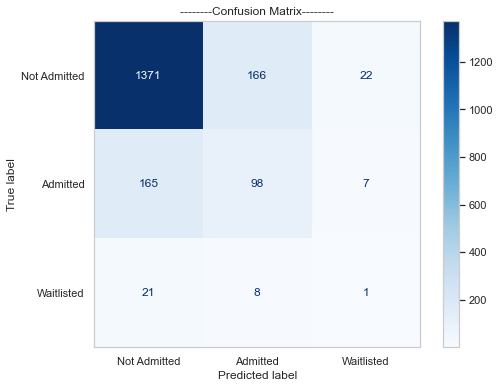

In [28]:
# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Displaying the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay(cm, display_labels=['Not Admitted', 'Admitted', 'Waitlisted']).plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('--------Confusion Matrix--------')
plt.grid(False)
plt.show()

The confusion matrix provides a summary of our model's performance by illustrating how frequently the predictions were correct or incorrect across categories.

For instance, the model accurately predicted 1,371 instances for the 'Not Admitted' category. However, it incorrectly classified 165 cases as 'Not Admitted' when they were actually 'Admitted' and so on.
_____________________________________________________________________________________________________________________________________________________________________________________________

## TASK 4: Feature Importance
- We will extract and visualize the feature importance for the dataset as Decision Trees provide feature importance scores that help understand which features contribute the most to the predictions.
- We will discuss how we would use this information to either refine the model.

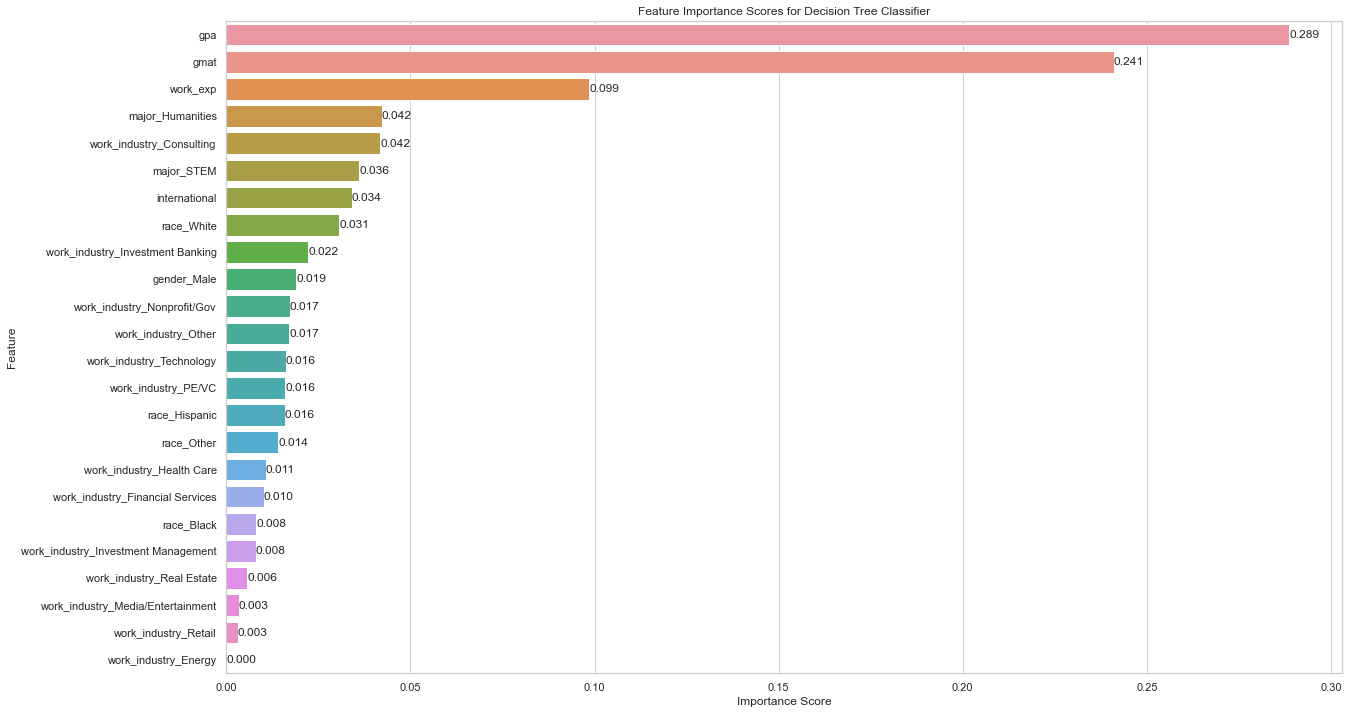

In [29]:
# Extract feature importance scores
featureImportance = dtClassifier.feature_importances_

# Create a DataFrame for better visualization
featuresDF = pd.DataFrame({
    'Feature': X.columns,  # Column names from the dataset
    'Importance': featureImportance  # Corresponding importance scores
})

# Sort the features by importance score
featuresDF = featuresDF.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(20, 12))
ax = sns.barplot(x='Importance', y='Feature', data=featuresDF)
plt.title('Feature Importance Scores for Decision Tree Classifier')
plt.xlabel('Importance Score')
plt.ylabel('Feature')

# Add the values against the bars
for index, value in enumerate(featuresDF['Importance']):
    ax.text(value, index, f'{value:.3f}', va='center')  # Format to 3 decimal places
plt.show()


##### The bar plot above provides a clear representation of the importance scores of the features. 
##### We will now utilize this information to begin our feature engineering experiments, with the aim of refining the model and potentially improving its accuracy.

- Exp 1: We will eliminate the features with importance scores below 0.01 and rebuild the model to assess its accuracy.


Accuracy of New Decision Tree classifier on test set: 0.78536847767617

Accuracy of Original Decision Tree classifier on test set: 0.7907477138246369


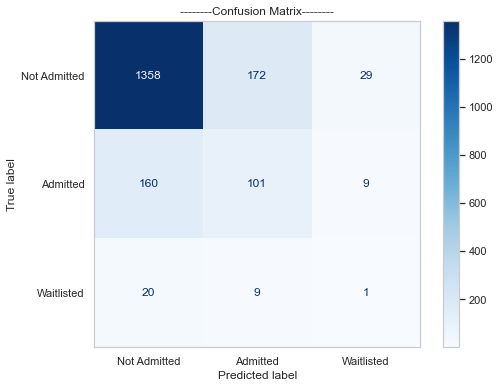

In [30]:
# Defining a threshold for dropping features
threshold = 0.01

# Get the list of features to drop
features_to_drop = featuresDF[featuresDF['Importance'] < threshold]['Feature'].tolist()

# Assuming mbaDataEncoded is your original DataFrame
mbaDataEncoded_dropped = mbaDataEncoded.drop(columns=features_to_drop)

X = mbaDataEncoded_dropped.drop('admission', axis=1)    # Independent Features
y = mbaDataEncoded_dropped['admission']                 # Dependent Feature

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

dtClassifier = DecisionTreeClassifier() # Model Initialisation

dtClassifier.fit(X_train, y_train)  # Fiting the Model with Training Data

# Predicting the Test set results
y_pred = dtClassifier.predict(X_test)

exp1_accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy of New Decision Tree classifier on test set:", exp1_accuracy)
print("\nAccuracy of Original Decision Tree classifier on test set:", accuracy)

# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Displaying the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay(cm, display_labels=['Not Admitted', 'Admitted', 'Waitlisted']).plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('--------Confusion Matrix--------')
plt.grid(False)
plt.show()


##### We observe that removing the features with threshold score less than 0.01 from the dataset has no impact on the model's accuracy.

- Exp 2: We will create the following features and then checking the accuracy:
    1. gpa`*`gmat
    2. gpa`*`work_exp
    3. gmat`*`work_exp
    4. gpa`*`gmat`*`work_exp 



Accuracy of New Decision Tree classifier on test set: 0.7724583109198494

Accuracy of Original Decision Tree classifier on test set: 0.7907477138246369
Accuracy: 0.7907


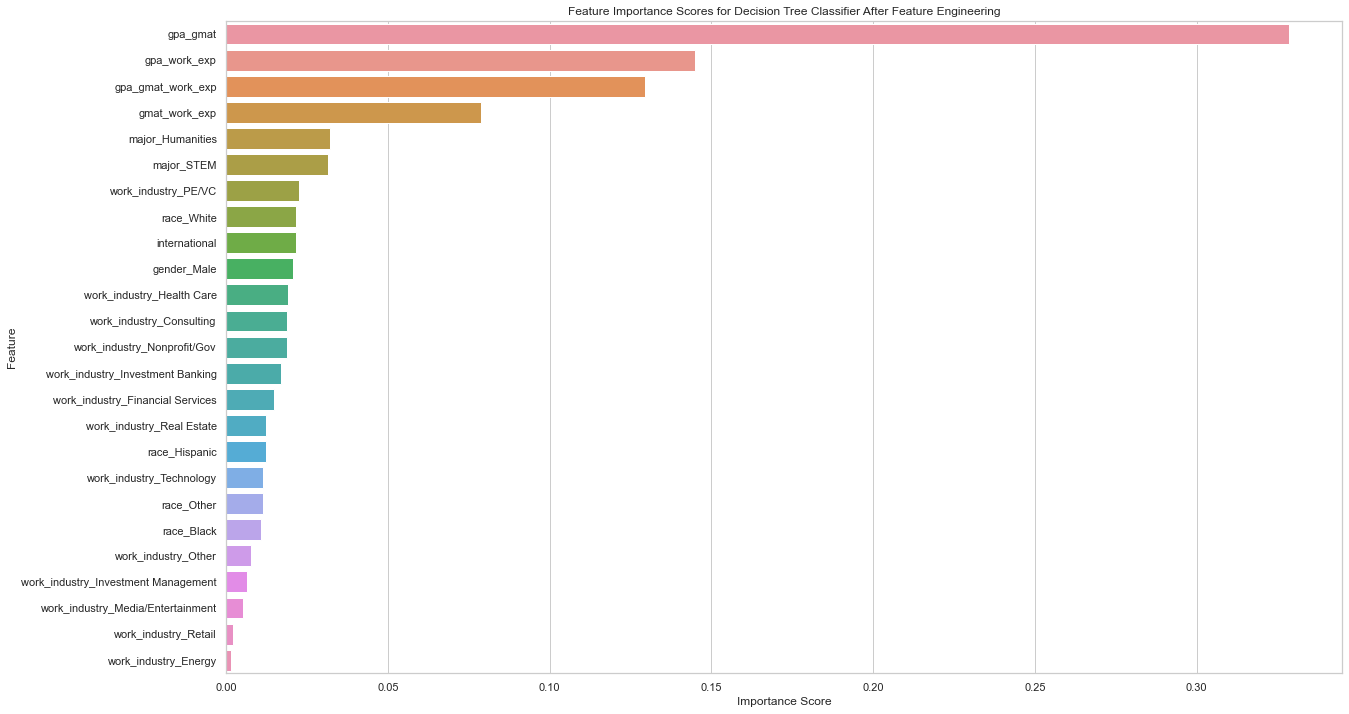

In [31]:
# Step 1: Create new features
mbaDataEncoded['gpa_gmat'] = mbaDataEncoded['gpa'] * mbaDataEncoded['gmat']
mbaDataEncoded['gpa_work_exp'] = mbaDataEncoded['gpa'] * mbaDataEncoded['work_exp']
mbaDataEncoded['gmat_work_exp'] = mbaDataEncoded['gmat'] * mbaDataEncoded['work_exp']
mbaDataEncoded['gpa_gmat_work_exp'] = mbaDataEncoded['gpa'] * mbaDataEncoded['gmat'] * mbaDataEncoded['work_exp']

# Step 2: Remove the original features
mbaDataReduced = mbaDataEncoded.drop(columns=['gpa', 'gmat', 'work_exp'])

# Step 3: Prepare the feature matrix (X) and target variable (y)
X = mbaDataReduced.drop(columns=['admission'])  # Assuming 'admission' is your target variable
y = mbaDataReduced['admission']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 4: Train the Decision Tree Classifier
dtClassifier = DecisionTreeClassifier(random_state=499)
dtClassifier.fit(X_train, y_train)

# Step 5: Check the accuracy
y_pred = dtClassifier.predict(X_test)
exp2_accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy of New Decision Tree classifier on test set:", exp2_accuracy)
print("\nAccuracy of Original Decision Tree classifier on test set:", accuracy)
print(f'Accuracy: {accuracy:.4f}')

# Step 6: Show the feature importance
featureImportance = dtClassifier.feature_importances_
featuresDF = pd.DataFrame({
    'Feature': X.columns,
    'Importance': featureImportance
})
featuresDF = featuresDF.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(20, 12))
sns.barplot(x='Importance', y='Feature', data=featuresDF)
plt.title('Feature Importance Scores for Decision Tree Classifier After Feature Engineering')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


##### I introduced new features to capture the interactions between key variables like GPA, GMAT, and Work Experience, with the goal of revealing more complex, non-linear relationships within the data. This approach was intended to provide the model with additional information to potentially improve predictive accuracy while preserving insights from individual features. However, the results did not meet expectations, as the accuracy of the updated model shows little to no improvement compared to the original model.

- Exp 3: In this experiment, we are trying out hyperparameter tuning with GRIDSEARCHCV and RANDOMSEARCHCV.

In [32]:
# Code adopted from chatGPT.

# Defining Features and Target Vraiables.
X = mbaDataEncoded.drop(columns=['admission'])  # Features
y = mbaDataEncoded['admission']                   # Target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=499, stratify=y)

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
}

# Initialize the Decision Tree Classifier
dtClassifier = DecisionTreeClassifier(random_state=42)

# Hyperparameter Tuning using Grid Search
grid_search = GridSearchCV(estimator=dtClassifier, 
                           param_grid=param_grid, 
                           scoring='accuracy', 
                           cv=5, 
                           verbose=1, 
                           n_jobs=-1)

# Fit Grid Search
grid_search.fit(X_train, y_train)

# Train the best model from Grid Search
best_grid_model = grid_search.best_estimator_

# Fit the model to the training data
best_grid_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_grid_model.predict(X_test)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy after Grid Search: {test_accuracy:.4f}\n")



# Hyperparameter Tuning using Randomized Search
random_search = RandomizedSearchCV(estimator=dtClassifier, 
                                   param_distributions=param_grid, 
                                   n_iter=100, 
                                   scoring='accuracy', 
                                   cv=5, 
                                   verbose=1, 
                                   random_state=499, 
                                   n_jobs=-1)

# Fit Randomized Search
random_search.fit(X_train, y_train)

# Train and check accuracy for Randomized Search
best_random_model = random_search.best_estimator_

# Fit the model to the training data
best_random_model.fit(X_train, y_train)

# Predict on the test set
y_pred_random = best_random_model.predict(X_test)

# Calculate accuracy on the test set
test_accuracy_random = accuracy_score(y_test, y_pred_random)
print(f"\nTest Accuracy after Randomized Search: {test_accuracy_random:.4f}")

print("\nAccuracy of Old Decision Tree classifier on test set:", accuracy)


Fitting 5 folds for each of 270 candidates, totalling 1350 fits

Test Accuracy after Grid Search: 0.8386

Fitting 5 folds for each of 100 candidates, totalling 500 fits

Test Accuracy after Randomized Search: 0.8386

Accuracy of Old Decision Tree classifier on test set: 0.7907477138246369


##### The code uses hyperparameter tuning methods, Grid Search and Randomized Search, to improve the Decision Tree Classifier by testing different combinations of settings. The goal is to find the best settings that increase the model's accuracy. This helps make the model better at predicting and provides a stronger solution to the classification task.

##### Both Grid and Randomized Search produced better results than the original Decision Tree Classifier, improving the accuracy from 78% to 83%.
___________________________________________________________________________________________________________________________________________________________________________________________

### CONCLUSION

In this analysis, we arrived at the following conclusions:
- We performed data preprocessing, which included defining features, identifying categorical variables, handling missing values through various techniques, and applying one-hot encoding for label conversion.
- A Decision Tree Classifier model was successfully built and evaluated to predict the 'Admission Status' of MBA applicants.
- The model showed a reasonable fit with an accuracy score of 79%, and we also constructed a confusion matrix for further evaluation.
- The confusion matrix revealed a bias in the data due to a large number of missing values in the 'Admission' feature, which were labeled as 'Not Admitted' (5194) compared to the smaller numbers of 'Admitted' (900) and 'Waitlisted' (100), skewing the results.
- We ranked the feature importance and observed that dropping the least important features, using a threshold of 0.01, did not affect the model's accuracy.
- Additional feature engineering, where new features were introduced to capture potential non-linear relationships, also had no significant impact on model performance.
- Finally, we applied Grid Search and Randomized Search to optimize the model's hyperparameters, resulting in a slight improvement in accuracy from 79% to 83%.